<a href="https://colab.research.google.com/github/anjanidwilestari/BigData_2023/blob/main/diabetes_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DIABETES

Goal : Memprediksi timbulnya diabetes berdasarkan pembobotan diagnosis

Model Klasifikasi menggunakan Linier Regression

Link Data : https://www.kaggle.com/datasets/saurabh00007/diabetescsv

In [ ]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=341d4f2fd2afb22401c5554eef5dd24b5f89ad93ff1aadb2efb03588645c943e
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("diabetes_logistic").getOrCreate()

In [4]:
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/UAS_BigData/diabetes.csv", inferSchema=True, header=True)

In [5]:
print(f"There are {df.count()} rows and {len(df.columns)} columns in the dataset.")

There are 768 rows and 9 columns in the dataset.


In [6]:
df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 2 rows



In [7]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [8]:
df.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
BMI,768,31.992578124999977,7.884160320375441,0.0,67.1
DiabetesPedigreeFunction,768,0.4718763020833327,0.331328595012775,0.078,2.42
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


In [9]:
df.groupby("Outcome").count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



In [10]:
import matplotlib.pyplot as plt

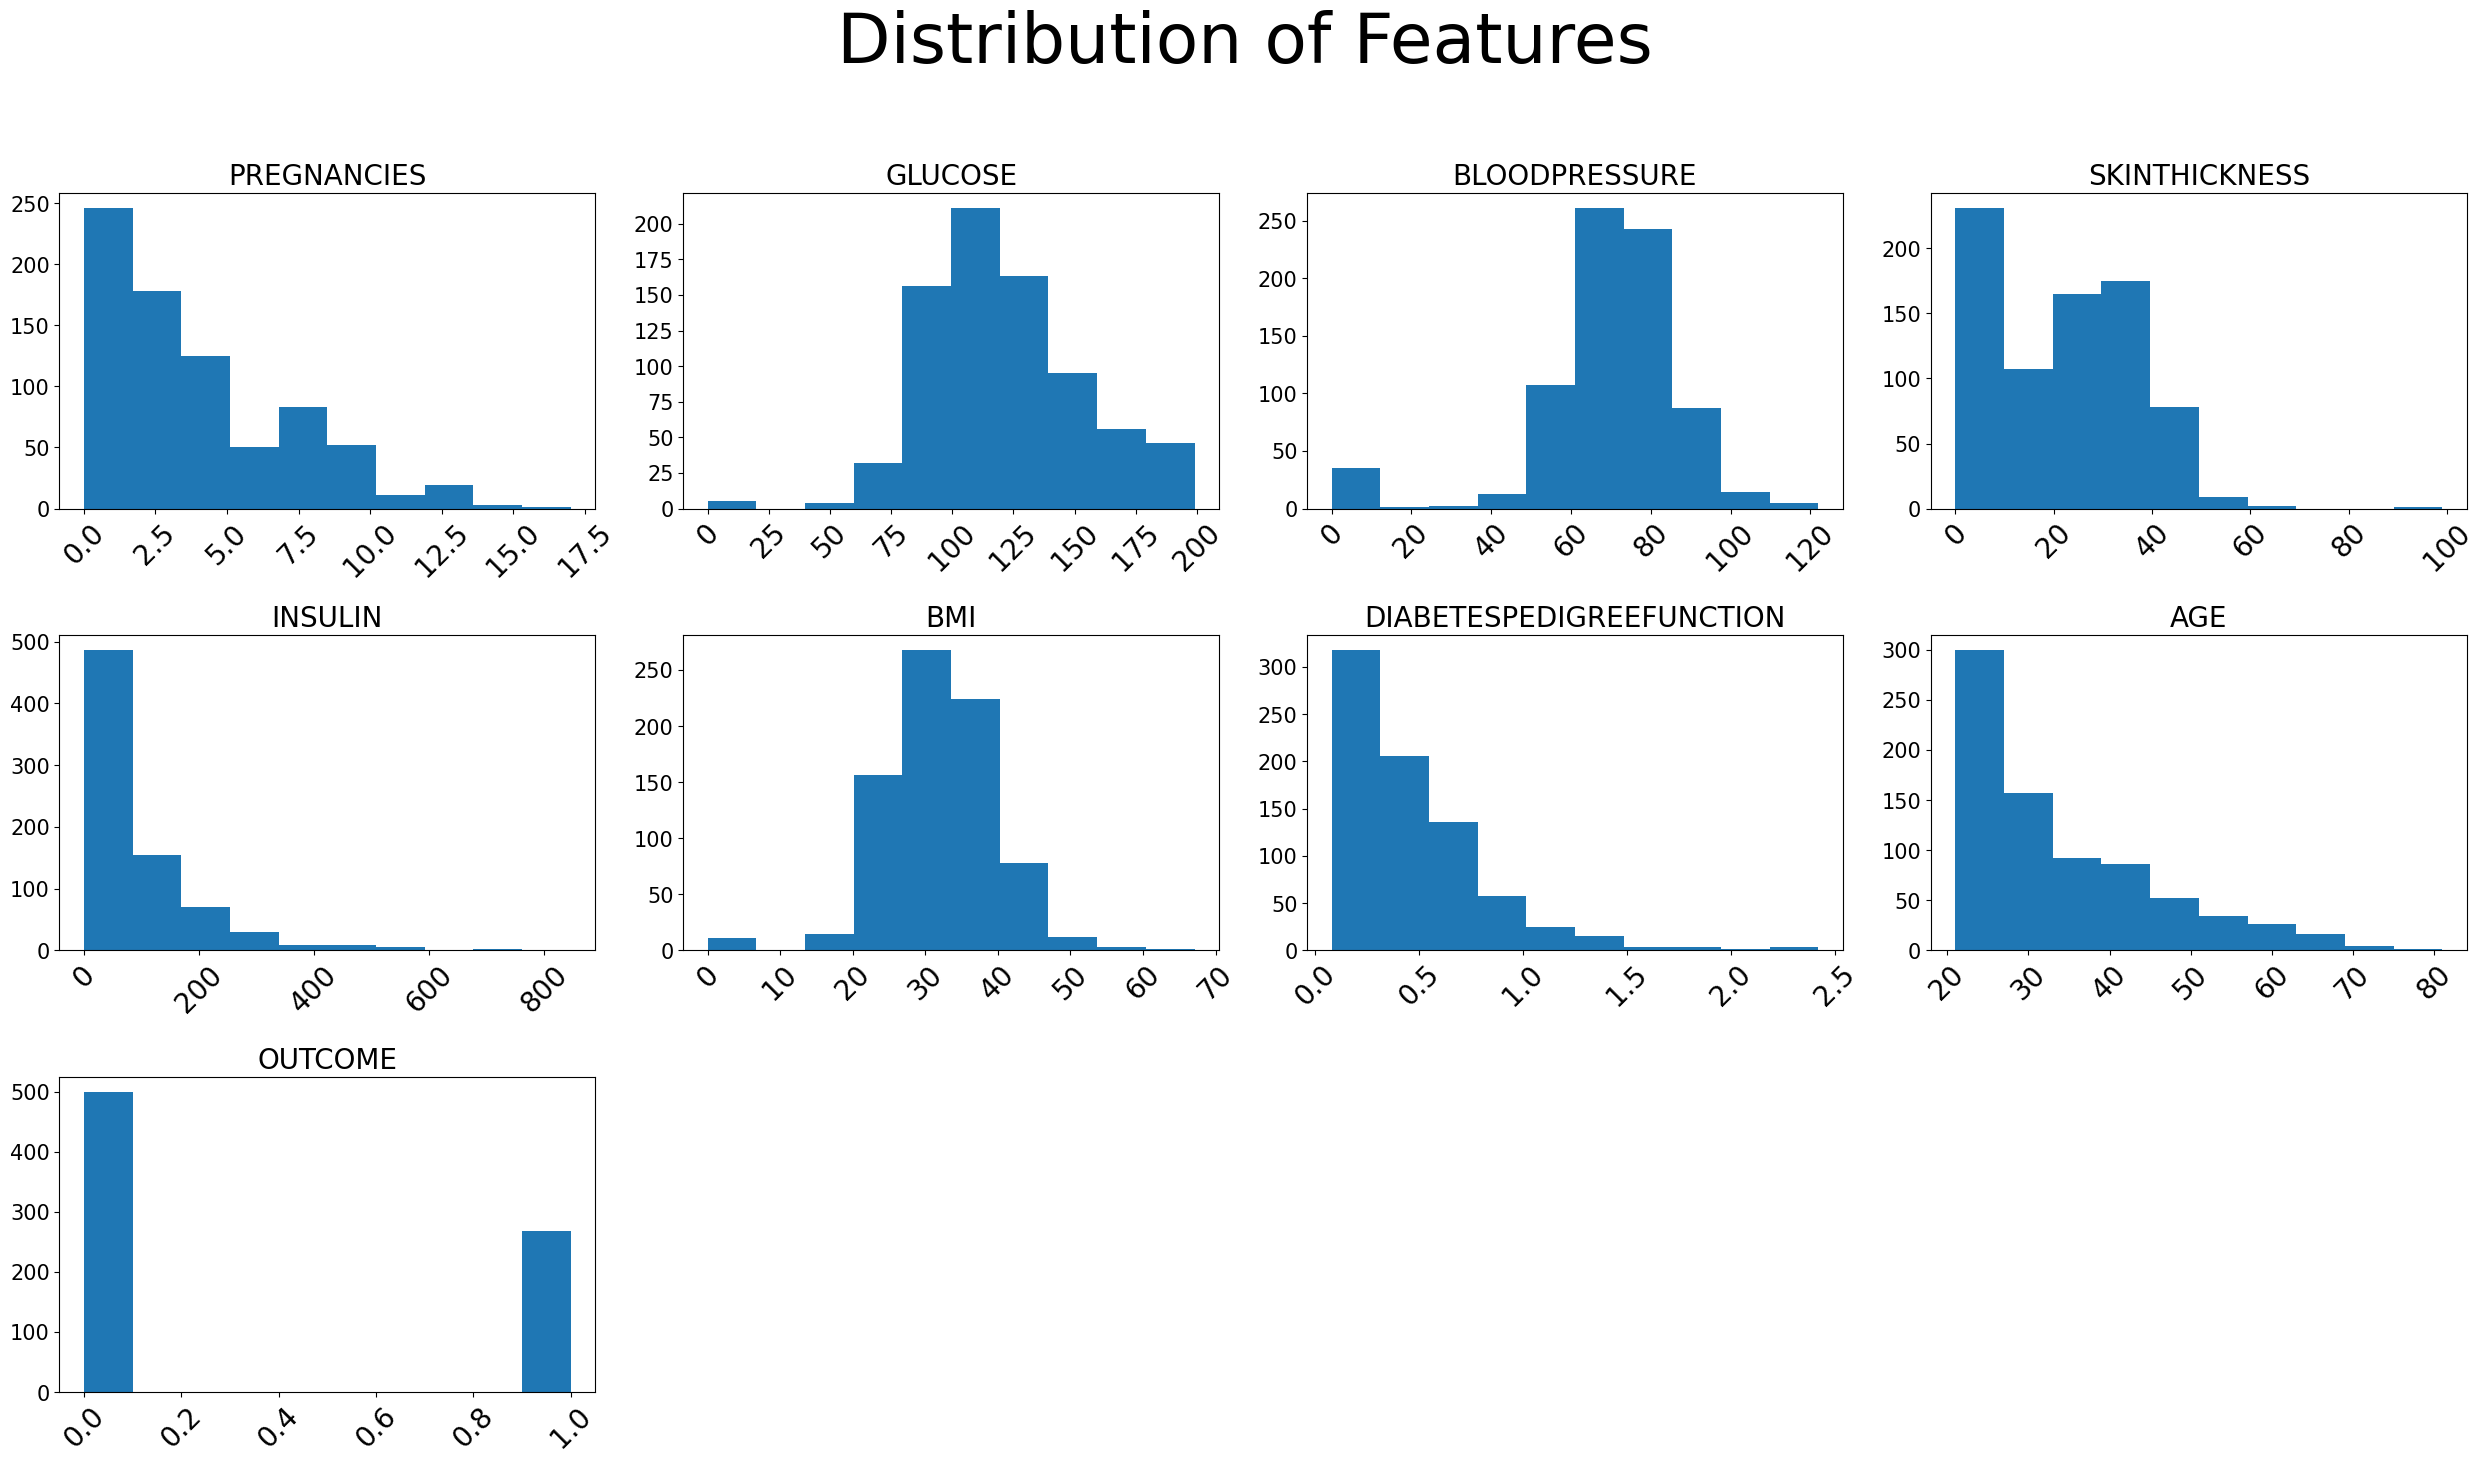

In [11]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")

for col, num in zip(df.toPandas().describe().columns, range(1,11)):
  ax = fig.add_subplot(3, 4, num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [12]:
from pyspark.sql.functions import isnan, when, count, col

In [13]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


## User Defined Functions (UDF)

In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [15]:
y_udf = udf(lambda y: "no" if y==0 else "yes", StringType())

In [16]:
df = df.withColumn("HasDiabetes", y_udf('Outcome')).drop("Outcome")

In [17]:
df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
only showing top 2 rows



In [18]:
def udf_multiple(age):
  if (age<=25):
    return "Under 25"
  elif (age >=25 and age <= 35):
    return "Between 25 and 35"
  elif (age > 35 and age < 50):
    return "Between 36 and 50"
  elif (age >= 50):
    return "Over 50"
  else: return "NA"

In [19]:
age_udf = udf(udf_multiple)
df = df.withColumn('age_udf', age_udf('Age'))

In [20]:
df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|          age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|Between 25 and 35|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
only showing top 2 rows



In [21]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank, sum, col, desc
from pyspark.sql import Window

In [22]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
tab = df.select(['age_udf', 'Glucose']).\
    groupBy('age_udf').\
        agg(
            F.count('Glucose').alias('UserCount'),
            F.mean('Glucose').alias('Glucose_AVG'),
            F.min('Glucose').alias('Glucose_MIN'),
            F.max('Glucose').alias('Glucose_MAX')).\
        withColumn('total', sum(col('UserCount')).over(window)).\
        withColumn('Percent', col('UserCount')*100 / col('total')).\
        drop(col('total')).sort(desc('Percent'))

In [23]:
tab.show()

+-----------------+---------+------------------+-----------+-----------+------------------+
|          age_udf|UserCount|       Glucose_AVG|Glucose_MIN|Glucose_MAX|           Percent|
+-----------------+---------+------------------+-----------+-----------+------------------+
|         Under 25|      267|110.71910112359551|          0|        199|         34.765625|
|Between 25 and 35|      231|121.67099567099567|         71|        198|         30.078125|
|Between 36 and 50|      181|125.74033149171271|          0|        197|23.567708333333332|
|          Over 50|       89| 139.5505617977528|         57|        197|11.588541666666666|
+-----------------+---------+------------------+-----------+-----------+------------------+



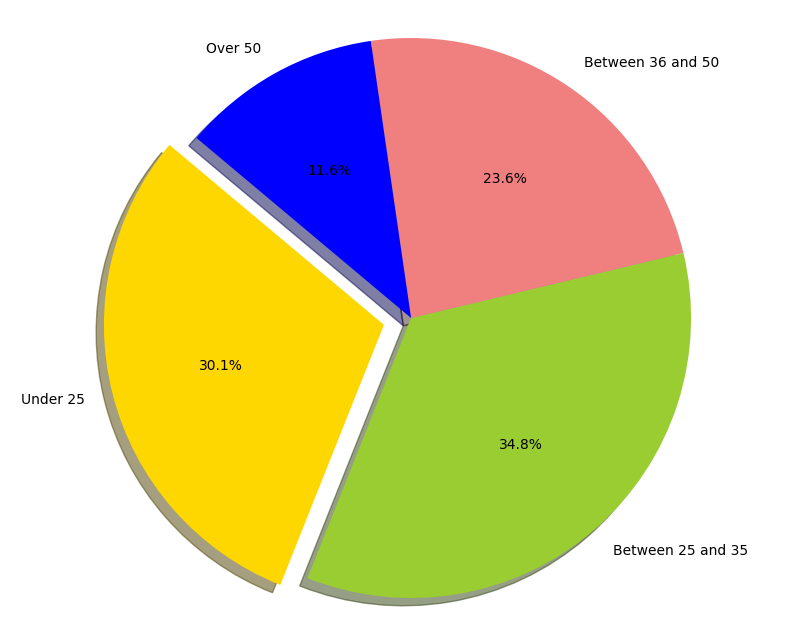

In [24]:
labels = list(tab.select('age_udf').distinct().toPandas()['age_udf'])
sizes = list(tab.select('Percent').distinct().toPandas()['Percent'])
colors = ['gold','yellowgreen','lightcoral','blue','lightskyblue','green','red']
explode = (0.1, 0.0, 0.0, 0.0)

plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Pearson Correlation

In [25]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [26]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [27]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [28]:
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00


# Machine Learning Prep
1. StringIndexer
1. OneHotEncoderEstimator
1. VectorAssembler
1. LabelIndexer
1. StandardScaler

## Pipeline is the Future!@!@
Going to do this twice:
1. Manually
1. Pipeline

In [29]:
from pyspark.ml.feature import StringIndexer

In [30]:
stringIndexer = StringIndexer()\
                  .setInputCol("age_udf")\
                  .setOutputCol('age_udfindex')

In [31]:
age_udf_indexer_model = stringIndexer.fit(df)
age_udf_index_df = age_udf_indexer_model.transform(df)
age_udf_index_df.toPandas()[['age_udf','age_udfindex']].head()

,age_udf,age_udfindex
0,Over 50,3.0
1,Between 25 and 35,1.0
2,Between 25 and 35,1.0
3,Under 25,0.0
4,Between 25 and 35,1.0


In [32]:
from pyspark.ml.feature import OneHotEncoder

In [33]:
encoder = OneHotEncoder()\
            .setInputCols(['age_udfindex'])\
            .setOutputCols(['age_encoded'])

In [34]:
encoder_model = encoder.fit(age_udf_index_df)
encoder_df = encoder_model.transform(age_udf_index_df)
encoder_df.toPandas()[['age_udf','age_udfindex','age_encoded']].head()

,age_udf,age_udfindex,age_encoded
0,Over 50,3.0,"(0.0, 0.0, 0.0)"
1,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
2,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
3,Under 25,0.0,"(1.0, 0.0, 0.0)"
4,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"


In [35]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [36]:
encoder_df.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'HasDiabetes',
 'age_udf',
 'age_udfindex',
 'age_encoded']

In [37]:
assembler = VectorAssembler()\
              .setInputCols(['age_encoded', 'Pregnancies',
                              'Glucose',
                              'BloodPressure',
                              'SkinThickness',
                              'Insulin',
                              'BMI',
                              'DiabetesPedigreeFunction',])\
              .setOutputCol('vec_features')

In [38]:
assembler_df = assembler.transform(encoder_df)

In [39]:
assembler_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,HasDiabetes,age_udf,age_udfindex,age_encoded,vec_features
0,6,148,72,35,0,33.6,0.627,50,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 3..."
1,1,85,66,29,0,26.6,0.351,31,no,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26..."
2,8,183,64,0,0,23.3,0.672,32,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23..."
3,1,89,66,23,94,28.1,0.167,21,no,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 2..."
4,0,137,40,35,168,43.1,2.288,33,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0,..."


In [40]:
label_indexer = StringIndexer()\
                  .setInputCol('HasDiabetes')\
                  .setOutputCol('label')

In [41]:
label_indexer_model = label_indexer.fit(assembler_df)
label_indexer_df = label_indexer_model.transform(assembler_df)

In [42]:
label_indexer_df.select('HasDiabetes','label').toPandas().head()

,HasDiabetes,label
0,yes,1.0
1,no,0.0
2,yes,1.0
3,no,0.0
4,yes,1.0


In [43]:
from pyspark.ml.feature import StandardScaler

In [44]:
scaler = StandardScaler()\
            .setInputCol('vec_features')\
            .setOutputCol('features')

In [45]:
scaler_model = scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)

In [46]:
pd.set_option('display.max_colwidth',100)
scaler_df.select('vec_features','features').toPandas().head()

,vec_features,features
0,"[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627]","[0.0, 0.0, 0.0, 1.7806383732194306, 4.628960915766174, 3.7198138711154307, 2.1940523222807116, 0..."
1,"[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351]","[0.0, 2.1791401333367157, 0.0, 0.29677306220323846, 2.658524850271114, 3.4098293818558116, 1.817..."
2,"[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672]","[0.0, 2.1791401333367157, 0.0, 2.3741844976259077, 5.723647618818986, 3.306501218769272, 0.0, 0...."
3,"[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167]","[2.098474993842542, 0.0, 0.0, 0.29677306220323846, 2.783631902048578, 3.4098293818558116, 1.4418..."
4,"[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288]","[0.0, 2.1791401333367157, 0.0, 0.0, 4.284916523378148, 2.0665632617307947, 2.1940523222807116, 1..."


In [47]:
from pyspark.ml import Pipeline

In [48]:
pipeline_stages = Pipeline()\
                    .setStages([stringIndexer,
                                encoder,
                                assembler,
                                label_indexer,
                                scaler])

In [49]:
pipeline_model = pipeline_stages.fit(df)

In [50]:
pipeline_df = pipeline_model.transform(df)

In [51]:
pipeline_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,HasDiabetes,age_udf,age_udfindex,age_encoded,vec_features,label,features
0,6,148,72,35,0,33.6,0.627,50,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627]",1.0,"[0.0, 0.0, 0.0, 1.7806383732194306, 4.628960915766174, 3.7198138711154307, 2.1940523222807116, 0..."
1,1,85,66,29,0,26.6,0.351,31,no,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351]",0.0,"[0.0, 2.1791401333367157, 0.0, 0.29677306220323846, 2.658524850271114, 3.4098293818558116, 1.817..."
2,8,183,64,0,0,23.3,0.672,32,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672]",1.0,"[0.0, 2.1791401333367157, 0.0, 2.3741844976259077, 5.723647618818986, 3.306501218769272, 0.0, 0...."
3,1,89,66,23,94,28.1,0.167,21,no,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167]",0.0,"[2.098474993842542, 0.0, 0.0, 0.29677306220323846, 2.783631902048578, 3.4098293818558116, 1.4418..."
4,0,137,40,35,168,43.1,2.288,33,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288]",1.0,"[0.0, 2.1791401333367157, 0.0, 0.0, 4.284916523378148, 2.0665632617307947, 2.1940523222807116, 1..."


# Pipline the Easy Way

In [52]:
categoricalColumns = ['age_udf']
numericalColumns = ['Pregnancies',
                              'Glucose',
                              'BloodPressure',
                              'SkinThickness',
                              'Insulin',
                              'BMI',
                              'DiabetesPedigreeFunction']
stages = []
for categoricalCol in categoricalColumns:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+'_index')
  encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol+"_class_vec"])
  stages += [stringIndexer, encoder]

label_string_indexer = StringIndexer(inputCol='HasDiabetes', outputCol='label')
stages += [label_string_indexer]
assemblerInputs = [c + '_class_vec' for c in categoricalColumns] + numericalColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='vec_features')
stages += [assembler]
scaler = StandardScaler(inputCol='vec_features',outputCol='features')
stages += [scaler]


In [53]:
cols = df.columns
pipeline = Pipeline(stages=stages)
df_pipe = pipeline.fit(df).transform(df)
selectedCols = ['label','features'] + cols
df2 = df_pipe.select(selectedCols)
df2.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- HasDiabetes: string (nullable = true)
 |-- age_udf: string (nullable = true)



# Train/Test Split

In [54]:
print(f"There are {df2.count()} records in total. Split the data into training and test sets (20% held out for testing)")

There are 768 records in total. Split the data into training and test sets (20% held out for testing)


In [55]:
train, test = df2.randomSplit([0.8, 0.2], seed=42)
print(f"Training Data Size: {train.count()}")
print(f"Test Data Size: {test.count()}")

Training Data Size: 645
Test Data Size: 123


In [56]:
train.groupby('HasDiabetes').count().show()

+-----------+-----+
|HasDiabetes|count|
+-----------+-----+
|         no|  426|
|        yes|  219|
+-----------+-----+



# Model Training
- Logistic Regression
- Since it's a classification problem {Predict: HasDiabetes}

In [57]:
from pyspark.ml.classification import LogisticRegression

In [58]:
lr = LogisticRegression(featuresCol='features',labelCol='label', maxIter=5)
model = lr.fit(train)
pred = model.transform(test)
pred.select('label','features', 'rawPrediction','prediction','probability').toPandas().head()

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.098474993842542, 0.0, 0.0, 0.5935461244064769, 2.314480457883087, 0.0, 0.0, 0.0, 0.0, 0.30785...","[5.786263151932198, -5.786263151932198]",0.0,"[0.9969399618066707, 0.0030600381933293397]"
1,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 3.1902298203253365, 3.8748061157452405, 1.4418058117844677, 0...","[4.901746474789263, -4.901746474789263]",0.0,"[0.9926212613601004, 0.007378738639899574]"
2,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 3.1589530573809705, 3.2031730556827323, 0.0, 0.0, 2.777721293...","[3.299195523745217, -3.299195523745217]",0.0,"[0.9644012021480102, 0.03559879785198983]"
3,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 4.1285327086563175, 4.02979836037505, 0.0, 0.0, 4.10950547470...","[1.3324138737723867, -1.3324138737723867]",0.0,"[0.7912396374973134, 0.2087603625026866]"
4,0.0,"(0.0, 2.1791401333367157, 0.0, 1.7806383732194306, 3.00256924265914, 0.0, 0.0, 0.0, 3.0060271527...","[1.9955763360462573, -1.9955763360462573]",0.0,"[0.8803318386933476, 0.11966816130665237]"


# Model Evaluation

In [59]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [60]:
eval = BinaryClassificationEvaluator()

In [61]:
print(f"Test Area Under ROC: {eval.evaluate(pred)}")

Test Area Under ROC: 0.8348041919470488


# Model Accruary

In [62]:
acc = pred.filter(pred.label == pred.prediction).count() / float(pred.count())

In [63]:
print(f"Accuracy: {acc}")

Accuracy: 0.7317073170731707


In [64]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [65]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [66]:
paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]) # regularization parameter
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) # Elastic Net Param (Ridge=0, Lasso=1)
    .addGrid(lr.maxIter, [1,5,10, 20]) # Max Iterations?
    .build()
)
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=eval, numFolds=5)

cv_model = cv.fit(train)


In [67]:
# Best Model Performance
pred = cv_model.transform(test)
print(f"Test Area Under ROC: {eval.evaluate(pred)}")

Test Area Under ROC: 0.8320463320463318


In [68]:
acc = pred.filter(pred.label == pred.prediction).count() / float(pred.count())
print(f"Accuracy: {acc}")

Accuracy: 0.7398373983739838


# Best Model Feature Weights

In [69]:
df2.columns

['label',
 'features',
 'Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'HasDiabetes',
 'age_udf']

In [70]:
weights = cv_model.bestModel.coefficients
weights = [(float(w), ) for w in weights]
weights_df = spark.createDataFrame(weights, ['Feature Weight'])
weights_df.toPandas().head(10)

,Feature Weight
0,-0.270309
1,0.000000
2,0.100706
3,0.306943
4,1.061028
5,-0.054714
6,-0.039568
7,-0.056126
8,0.533944
9,0.398504


# Best Model Parameters

In [71]:
best_model = cv_model.bestModel

In [72]:
best = f"""
Best Model Parameters
=============================
regParam:\t{best_model._java_obj.getRegParam()}
MaxIter:\t{best_model._java_obj.getMaxIter()}
elasticNet:\t{best_model._java_obj.getElasticNetParam()}
"""

In [73]:
print(best)


Best Model Parameters
regParam:	0.01
MaxIter:	5
elasticNet:	0.5

